# Finite State Machine

References:
- [Context Managers and Python's with Statement](https://realpython.com/python-with-statement/)

Let $x_t$ be the stochastic process:

$$
dx_t=\mu dt+\sigma dw_t
$$

This kind of diffusion processes is called Wiener process.

We want to model $x_t$ with trend and flat behaviors. We call a process flat, if $\mu=0$, otherwise the process is called trend. There are two scenarios for trend processes, trend up and trend down, in which casees, the model parameter $\mu$ are positive and negative repectively. The flat process is also called Brownian motion and the trend process is Brown motion with drift.

With the above setting, there are three different contexts for the Wiener process, the context of flat, the context of up trend and the context of down trend. To model a Wiener process having three different contexts is to make the parameter $\mu$ depending on the hidden states that representing the contexts.

Let $S_t$ be the state process, where $S_t\in [-1,0,1]$, in other words, $S_t$ is a three states process, $-1$ corresponding to down trend, $0$ for flat and $1$ for trend up.

The fact that $\mu$ depends $S_t$, makes the law governing the process $x_t$ change over time according to the contexts that dictated by the state process. This kind of processes are called hidden markov processes.

In summary, we have

$$
dx_t=\mu(S_t) dt+\sigma dW_t
$$

with $S_t$ being a state process. The law governing $S_t$ is the transition probabilities, $P\{S_{t_i}=u\ |\ S_{t_{i-1}}=v\},\ u,v\in[-1,0,1]$. These probabilities are not depending on time.

We are going to develop a discrete simulator to simulate the hidden markov Wiener process $x_t$.


### The dependent models

In [62]:
import numpy as np
from nptyping import NDArray, Shape, Float64
from typing import Literal, Final, Protocol, TypeAlias
from dataclasses import dataclass

WienerParam:TypeAlias=tuple[float,float]
StateParam:TypeAlias=NDArray[Shape['3,3'],Float64]
State:TypeAlias=Literal[-1,0,1]

In [63]:
print(StateParam)

NDArray[Shape['3, 3'], Float]


In [64]:
@dataclass
class Wiener:
    params: list[WienerParam]

@dataclass
class FSMarkov:
    tranprobs: StateParam

# finite state markov model information interface
class FSMarkovInfo(Protocol):
    def transition(self,start:State, end:State)->list[float]: ...
    def states(self)->list[State]: ...
    def str2state(self,name:str)->State: ...

# diffusion process model information interface
class WienerInfo(Protocol):
    def Wiener(self,s:int)->WienerParam: ...

### Simulator interfaces

In [65]:
class FSMarkovSimulator(Protocol):
    def sim_state(self,s:State)->State: ...
    def state_process(self,s0:State,N:int)->list[State]: ...

class WienerSimulator(Protocol):
    def sim_Wiener(self,s:State,x0:float,dt:float,N:int)->list[float]: ...

### The core model
- a Wiener process model (an object of `Wiener` data class)
- a finite state markove model (an object of `FSMarkov` data class)
- Implements the `FSMarkovSimulator` interface
- Implements the `FSMarkovInfo` interface
- Implements the `WienerInfo` interface
- Implements the `WienerSimulator` interface

In [66]:
import math
from Contexts.Foldable import foldl
from functools import lru_cache
from itertools import repeat

class HiddenMarkov():
    def __init__(self,wp:Wiener,sp:FSMarkov):
        self.wp:Wiener=wp
        self.fsm:FSMarkov=sp
    SV:Final[list[State]]=[-1,0,1]; INTERVAL_A:Final[int]=1;INTERVAL_B:Final[int]=1000
    AB:Final[int]=INTERVAL_B-INTERVAL_A
    #------ Implementing the FSMarkovInfo ------
    def transition(self,start:State, end:State)->list[float]:
        if start in self.SV and end in self.SV: return self.fsm.tranprobs[start+1][end+1]
        else: raise ValueError("Illegal state value")
    def states(self)->list[State]: return self.SV
    def str2state(self,name:str)->State:
        match name:
            case 'downtrend': return -1
            case 'uptrend': return 1
            case 'flat': return 0
            case _: raise ValueError("Unknow state name")
    #------ Implementing the FSMarkovSimulator ------        
    def sim_state(self,s:State)->State:
        rn=np.random.randint(self.INTERVAL_A,self.INTERVAL_B)
        return self.sim_state_rn(s,rn)
    def sim_state_rn(self,s:State,rn:int)->State:
        p=self.fsm.tranprobs[s+1]
        if rn<self.AB*p[0]: return self.SV[0]
        elif rn<=self.AB*(p[1]+p[0]): return self.SV[1]
        else: return self.SV[2]
    @lru_cache(maxsize=128, typed=False)
    def state_process(self,s0:State,N:int)->list[State]:
        return foldl(lambda acc,x: acc+[self.sim_state_rn(acc[-1],x)],[s0],
                     np.random.randint(self.INTERVAL_A,self.INTERVAL_B,N))
    #------ Implementing the WienerInfo ------
    def wiener(self,s:int)->WienerParam: return self.wp.params[s+1]
    #------ Implementing the WienerSimulator ------
    #@lru_cache(maxsize=128, typed=False)
    def sim_wiener(self,s:State,x0:float,dt:float,N:int)->list[float]:
        sqrtdt=math.sqrt(dt);mu,sigma=self.wiener(s)
        return foldl(lambda acc,x: acc+[acc[-1]+x],[x0],np.random.normal(mu*dt,sigma*sqrtdt,N))

In [67]:
MP=Wiener([(-1.0,20.0),(0.0,30.0),(1.0,20.0)]) # diffusion process
TP=FSMarkov(np.array([[.25,.75,0.0],[.15,.7,.15],[0.0,.75,.25]])) # finite state markov process
m=HiddenMarkov(MP,TP)

In [68]:
[[m.transition(start,end) for end in m.states()] for start in m.states()]

[[0.25, 0.75, 0.0], [0.15, 0.7, 0.15], [0.0, 0.75, 0.25]]

In [69]:
[m.wiener(s) for s in m.states()]

[(-1.0, 20.0), (0.0, 30.0), (1.0, 20.0)]

## Simulating the state process

In [70]:
from contextlib import contextmanager
from typing import Generator
from typing_protocol_intersection import ProtocolIntersection as Has

@contextmanager
def single_state_simulator(s:State,m:Has[FSMarkovSimulator,FSMarkovInfo],verbal:bool=False)->Generator:
    if verbal:
        print("Entering the flat state...")
        print("State transition probabilites:",[m.transition(s,x) for x in m.states()])
    state=s; n=0; new_state=state
    while new_state==state: new_state=m.sim_state(state);n+=1

    yield (n,new_state)

    if verbal: print(f"leaving the {state} state")

In [71]:
np.random.seed(0)
N=pow(2,13)

def single_state_process(s:State,m:FSMarkovSimulator,verbal=False)->tuple[int,State]:
    with single_state_simulator(s,m,verbal) as fs:
        return tuple(fs)

### Checking random number generator
The simulated state appearing frequencies are close to the transition probablities, the errors are around in the order of $10^{-3}$ for $2^{13}$ realizations:

In [72]:
[
    list(map(
            lambda s: # computing the frequency of the transition to state s for state v
                len(list(
                    filter(lambda x:x==s,[m.sim_state(v) for _ in range(N)])
                ))/N,
            m.states() # for all possible transition states
        )
    )
    for v in m.states() # the state v visits all possible state in m.states()
]

[[0.2506103515625, 0.753662109375, 0.0],
 [0.146728515625, 0.7071533203125, 0.158447265625],
 [0.0, 0.7509765625, 0.25146484375]]

### Simulating single state processes
Using the transition proabability, compute the length of the current state before entering the next state.

In [73]:
single_state_process(m.str2state('flat'),m,True)

Entering the flat state...
State transition probabilites: [0.15, 0.7, 0.15]
leaving the 0 state


(1, -1)

`N` realizations for the flat state process:

In [74]:
fps=[single_state_process(m.str2state('flat'),m) for _ in range(N)]

In [75]:
fps[:20]

[(5, -1),
 (4, 1),
 (1, 1),
 (2, -1),
 (3, 1),
 (3, -1),
 (1, 1),
 (6, 1),
 (2, 1),
 (1, -1),
 (2, -1),
 (7, -1),
 (5, -1),
 (2, -1),
 (2, -1),
 (4, -1),
 (1, 1),
 (2, -1),
 (1, -1),
 (13, 1)]

`N` realizations for the uptrend state process:

In [76]:
uts=[single_state_process(m.str2state('uptrend'),m) for _ in range(N)]

In [77]:
uts[:20]

[(2, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (3, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0)]

`N` realizations for the downtrend state process:

In [78]:
dts=[single_state_process(m.str2state('downtrend'),m) for _ in range(N)]

In [79]:
dts[:20]

[(2, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0)]

### Full process simulation
We are testing several implementation as follows.
- Using while loop: easier to read (maybe), utilize the components developed earlier.
- Using `foldl`: tight and clean, can skip all the components developed earlier, but few times slower than the while loop.
- Using caching technique on `foldl`: dramatically improves the peformance.

In [80]:
def state_process_w(s0:State,m:HiddenMarkov,length:int)->list[State]:
    process:list[State]=[s0]
    while len(process)<length:
        l,ns=single_state_process(s0,m)
        process+=[s0]*l
        s0=ns
    return process[:(length+1)]

In [81]:
%%timeit
s=state_process_w(m.str2state('flat'),m,N)

38.2 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [82]:
%%time
s=state_process_w(0,m,N)

CPU times: user 35.6 ms, sys: 3.75 ms, total: 39.4 ms
Wall time: 38.7 ms


In [83]:
from itertools import repeat
from Contexts.Functor import ListFunctor
from Contexts.Foldable import foldl

In [84]:
def state_process(s0:State,m:HiddenMarkov,N:int)->list[State]:
    return foldl(lambda acc,_: acc+[m.sim_state(acc[-1])],[s0],repeat(1,N))

In [85]:
%%timeit
s=state_process(0,m,N)

104 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
%%time
s=state_process(0,m,N)

CPU times: user 116 ms, sys: 6.5 ms, total: 122 ms
Wall time: 122 ms


In [87]:
from functools import lru_cache

@lru_cache(maxsize=128, typed=False)
def state_process_cache(s0:State,m:HiddenMarkov,N:int)->list[State]:
    return foldl(lambda acc,_: acc+[m.sim_state(acc[-1])],[s0],repeat(1,N))

In [88]:
%%timeit
s=state_process_cache(0,m,N)

74.9 ns ± 0.514 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [89]:
%%time
s=state_process_cache(0,m,N)
s[:20]

CPU times: user 32 µs, sys: 4 µs, total: 36 µs
Wall time: 40.1 µs


[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Simulating Wiener processes
The discrete form of the Wiener process can be written as:

$$x_i=x_{i-1}+\mu \Delta t_i+\sigma\sqrt{\Delta t_i}\xi_i$$

where $\xi\sim N(0,1)$.

In [90]:
import math
@lru_cache(maxsize=128, typed=False)
def wiener_process_formula(mu:float,sigma:float,x0:float,dt:float,N:int)->list[float]:
    sqrtdt=math.sqrt(dt)
    return foldl(lambda acc,xi: acc+[acc[-1]+mu*dt+sigma*sqrtdt*xi],[x0],np.random.normal(0.0,1.0,N))

#@lru_cache(maxsize=128, typed=False)
def wiener_process(mu:float,sigma:float,x0:float,dt:float,N:int)->list[float]:
    sqrtdt=math.sqrt(dt)
    return foldl(lambda acc,x: acc+[acc[-1]+x],[x0],np.random.normal(mu*dt,sigma*sqrtdt,N))

In [91]:
mu=1.0; sigma=20.0; x0=0.0; dt=1.0/365; N=pow(2,13)
x=wiener_process(mu,sigma,x0,dt,N)

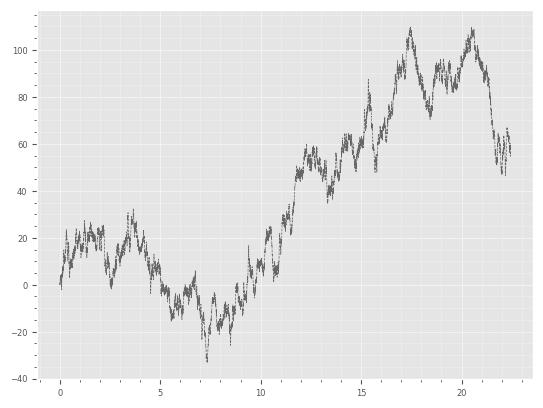

In [92]:
import matplotlib.pyplot as plt
from plot.qiplot import plot_ts
plt.style.use(['ggplot','../plot/presentation.mplstyle'])

t=[dt*i for i in range(N+1)]
fig,ax=plt.subplots()
plot_ts(ax,t,x)

In [93]:
m.wiener(m.str2state('uptrend'))

(1.0, 20.0)

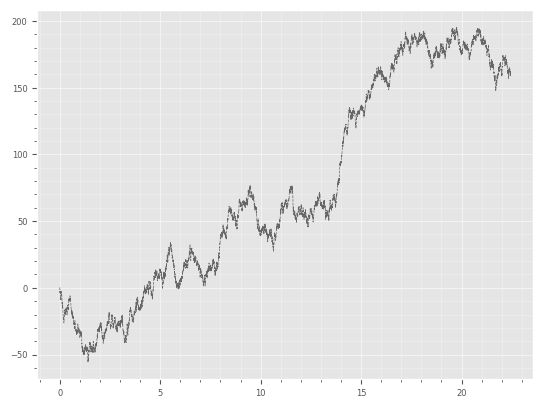

In [94]:
x=m.sim_wiener(m.str2state('uptrend'),x0,dt,N)
fig,ax=plt.subplots()
plot_ts(ax,t,x)

## Simulating a hidden markov process


In [95]:
n=4
N1=N>>n
N2=1<<n


## Model estimations

In [96]:
class FSMarkovEstimator(Protocol):
    def FSMEstimator(self,s:list[State])->StateParam: ...

class WienerProcessEstimator(Protocol):
    def WienerEstimator(self,x:list[float])->WienerParam: ...

### Estimating the finite state markov process
Given a simulated process $\{s_i\}_{i=1}^N,\ s_i\in S$, where $S$ is the state space, in this implementation,
$S=\{-1,0,1\}$ representing the down trend, flat and up trend repectively.

From the observed sequence $\{s_i\}_{i=1}^N$, we want to estimate the transitioin probablilites $p(S_v,S_u)=P\{s_i=S_u\ |\ s_{i-1}=S_v\}, i=1,\cdots,N, S_u,S_v\in S$. For a given $S_u, S_v\in S$, the estimator is as follows:
- Compute the number of occuring of the event $\{s_i=S_u\ |\ s_{i-1}=S_v\}$ in the sequence $\{s_i\}_{i=1}^N$.
- Compute the number of the occuring of the event $\{s_i=S_v\}$.
- The estimated transition probabability $p(S_v,S_u)$ is the ratio of the above two quantities.

This estimator is coded in the function `transition_pair_estimator`:
- `s1`: $S_v$
- `s2`: $S_u$
- `s0`: the initial value of the finite state markov process
- `s`: a realization of the finite state markov process

In [97]:
@lru_cache(maxsize=128, typed=False)
def transition_pair_estimator(s1:State,s2:State,s:tuple[State])->float:
    N=len(list(filter(lambda x:x==s1,s)))
    return sum(foldl(lambda acc,x:(x,acc[1]+[1]) if acc[0]==s1 and x==s2 else (x,acc[1]),(s[0],[]),s[1:])[1])/N

In [98]:
s=state_process(0,m,pow(2,13))

In [99]:
transition_pair_estimator(-1,0,tuple(s))

0.7437395659432388

In [100]:
[[transition_pair_estimator(s1,s2,tuple(s)) for s2 in m.states()] for s1 in m.states()]

[[0.25626043405676124, 0.7437395659432388, 0.0],
 [0.15212566160150248, 0.7024073757896534, 0.1452962267372375],
 [0.0, 0.7478031634446397, 0.2521968365553603]]

Comparing to the model parameters:

In [101]:
[[m.transition(start,end) for end in m.states()] for start in m.states()]

[[0.25, 0.75, 0.0], [0.15, 0.7, 0.15], [0.0, 0.75, 0.25]]

The erros are in the order of $10^{-2}$ from a realization of the process with length $2^{13}$.

Let's increase the length of the process to $2^{16}$ and check the result:

In [102]:
s=state_process(0,m,pow(2,16))
[[transition_pair_estimator(s1,s2,tuple(s)) for s2 in m.states()] for s1 in m.states()]

[[0.24407104115707753, 0.7559289588429224, 0.0],
 [0.15171824973319104, 0.7003201707577374, 0.147940234791889],
 [0.0, 0.746553209823352, 0.253446790176648]]

The errors are now in the order of $10^{-3}$, not a big gain in precision but it does gain.

### Estimating Wiener processes
Since the process $x_i$ statisfying

$$x_i=x_{i-1}+\mu\Delta t+\sigma\sqrt{\Delta t}\xi_i$$

where $\xi\sim N(0,1)$.

We have $\Delta x_i=x_i-x_{i-1}\sim N(\mu\Delta t,\sigma\sqrt{\Delta t})$, for $i=1,2,\cdots,N$, so the unbiased estimator for this normal distribution is as follows:

$$\mu\Delta t=\frac{1}{N}\sum_{i=1}^N \Delta x_i=\frac{1}{N}(x_N-x_0)$$

and

$$\sigma\sqrt{\Delta t}=\sqrt{\frac{1}{N-1}\sum_{i=1}^N\Delta(x_i-\mu)^2}$$

In [103]:
mu=1.0; sigma=20.0; x0=0.0; dt=1.0/365; N=pow(2,13)
t=[dt*i for i in range(N+1)]
x=m.sim_wiener(m.str2state('uptrend'),x0,dt,N)

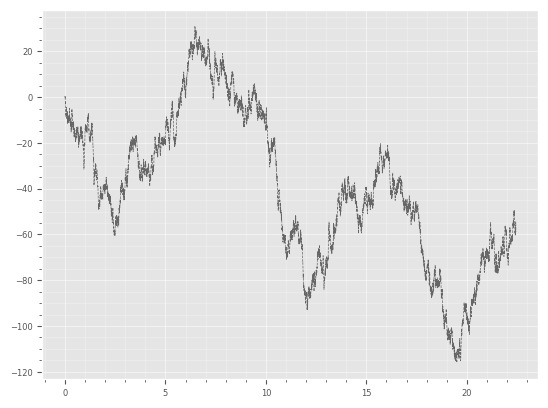

In [104]:
fig,ax=plt.subplots()
plot_ts(ax,t,x)

In [105]:
from scipy.stats import norm

@lru_cache(maxsize=128, typed=False)
def wiener_process_estimator(x:tuple[float],dt:float)->tuple[float,float]:
    dx=foldl(lambda acc,x:(x,acc[1]+[x-acc[0]]),(x[0],[]),x[1:])[1]
    mudt,stddt=norm.fit(dx)
    return (mudt/dt,stddt/math.sqrt(dt))

In [106]:
mue,sigmae=wiener_process_estimator(tuple(x),dt)
mudtf=(x[-1]-x[0])/N

In [107]:
print(mudtf/dt,mue,sigmae)

-2.6220674504486574 -2.622067450448658 19.96180052779348


In [108]:
norm.fit(norm.rvs(loc=mu*dt,scale=sigma*math.sqrt(dt),size=N))

(0.011110250153355743, 1.0532411691399919)

We get poor estimation on the drift based on ene realization of the Wiener process. Let's see the situation when more realizations are observed:

In [109]:
# N=pow(2,13), N>>2 is pow(2,11) which is 2048
samples=[norm.fit(norm.rvs(loc=mu*dt,scale=sigma*math.sqrt(dt),size=N)) for _ in range(N>>2)]

In [110]:
mudtN,sigmadtN=foldl(lambda acc,x: (acc[0]+x[0],acc[1]+x[1]),(0.0,0.0),samples)
mue=mudtN/(dt*len(samples)); sigmae=sigmadtN/(math.sqrt(dt)*len(samples))

In [111]:
print(mue,sigmae)

1.012200168331431 20.00160125714573


We get decent estimation on drift when `N>>2` realizations are available. Unfortunately, in practice, there is no such luxury. How to get decent estimation on drift is a research topic.

Next, we want to examine the situation when we can get good estimation from one realization. It is clear that the case should be arise from when the force of trend is very strong (relative to the noise). 

Let's see what would happend if we make the uptrend 10 folds stronger:

In [112]:
MP=Wiener([(-10.0,20.0),(0.0,30.0),(10.0,20.0)]) # diffusion process
TP=FSMarkov(np.array([[.25,.75,0.0],[.15,.7,.15],[0.0,.75,.25]])) # finite state markov process
m=HiddenMarkov(MP,TP)

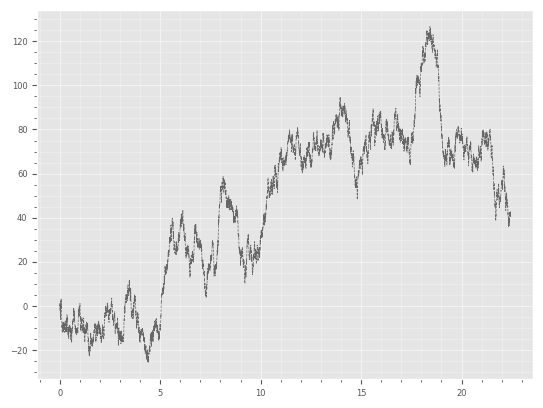

In [113]:
t=[dt*i for i in range(N+1)]
x=m.sim_wiener(m.str2state('uptrend'),x0,dt,N)
fig,ax=plt.subplots()
plot_ts(ax,t,x)

In [114]:
mue,sigmae=wiener_process_estimator(tuple(x),dt)
print(mue,sigmae)

1.9004628898742046 20.258075455321787


In [115]:
m.wiener(m.str2state('uptrend'))

(10.0, 20.0)

Now we reduce the strenght of trend by half:

In [116]:
MP=Wiener([(-5.0,20.0),(0.0,30.0),(5.0,20.0)]) # diffusion process
TP=FSMarkov(np.array([[.25,.75,0.0],[.15,.7,.15],[0.0,.75,.25]])) # finite state markov process
m=HiddenMarkov(MP,TP)

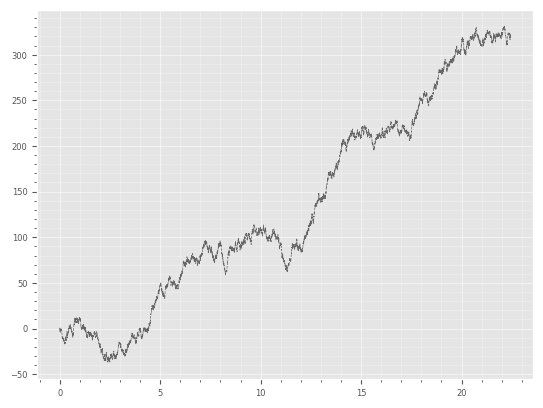

In [117]:
t=[dt*i for i in range(N+1)]
x=m.sim_wiener(m.str2state('uptrend'),x0,dt,N)
fig,ax=plt.subplots()
plot_ts(ax,t,x)

In [118]:
m.wiener(m.str2state('uptrend'))

(5.0, 20.0)

In [119]:
mue,sigmae=wiener_process_estimator(tuple(x),dt)
print(mue,sigmae)

14.182776288185611 19.780308454375326
